In [1]:
%matplotlib widget
import sys  
sys.path.insert(0, '/home/cbisot/pycode/MscThesis/')
from amftrack.pipeline.functions.post_processing.extract_study_zone import *
import pandas as pd
import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.paths.directory import run_parallel, find_state, directory_scratch, directory_project
from amftrack.notebooks.analysis.util import * 
from scipy import stats
from scipy.ndimage.filters import uniform_filter1d
from collections import Counter
from IPython.display import clear_output
from amftrack.notebooks.analysis.data_info import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams.update({
    "font.family": "verdana",
'font.weight' : 'normal',
'font.size': 20})
from amftrack.plotutil import plot_node_skel
from amftrack.notebooks.validation.util import *
from amftrack.pipeline.paths.directory import *
from amftrack.util import *
import pickle
from amftrack.pipeline.functions.post_processing.extract_study_zone import load_study_zone
from amftrack.pipeline.functions.post_processing.global_hypha import *

In [2]:
directory = directory_project
# update_analysis_info(directory)
analysis_info = get_analysis_info(directory)

In [3]:
select = analysis_info 


In [4]:
num = 4
rows = [row for (index, row) in select.iterrows()]
for index,row in enumerate(rows):
    path = f'{directory}{row["folder_analysis"]}'
    print(index,row["Plate"])
    try:
        a = np.load(f'{path}/center.npy')
    except:
        print(index,row["Plate"])
    if index == num:
        path_exp = f'{directory}{row["path_exp"]}'
        exp = pickle.load(open(path_exp, "rb"))
        exp.dates.sort()
        break

0 799
1 790
2 800
3 22
3 22
4 80


In [5]:
load_study_zone(exp)

In [24]:
hyph = choice(exp.hyphaes)

In [27]:
def gets_out_of_ROI(hyph,args):
    for t in hyph.ts:
        if not np.all(is_in_study_zone(hyph.end,t,1000,150)):
            return('out_of_ROI',t)
    return('out_of_ROI',None)

In [28]:
for hyph in exp.hyphaes:
    _,out = gets_out_of_ROI(hyph,None)
    if not out is None:
        break

In [31]:
is_in_study_zone(hyph.end,7,1000,150)

(True, False)

In [34]:
out

0

In [13]:
get_tot_length_C(hyph,None)
get_width(hyph,None)
get_tot_growth_C(hyph,None)
get_tot_length_pp(hyph,None)
get_tot_growth_pp(hyph,None)
get_timestep_stop_growth(hyph,None)
get_time_stop_growth(hyph,None)
get_time_init_growth(hyph,None)
get_mean_speed_growth(hyph,None)
get_timestep_anastomosis(hyph,None)
get_timestep_biological_stop_growth(hyph,None)

('tot_length_C', 778.8031681672331)

('av_width_final', 9.454561084918963)

failure in finding closest edge


('tot_growth_C', 195.70885456804268)

('tot_length_pp', 673.3976690076971)

('tot_growth_pp', 295.6652012834787)

('timestep_stop_growth', 27)

('time_stop_growth', 115.88333333333334)

('time_init_growth', 111.88333333333334)

failure in finding closest edge


('mean_speed', 46.58269423824297)

('timestep_anastomosis', 26)

('timestep_biological_stop_growth', None)

findfont: Font family ['verdana'] not found. Falling back to DejaVu Sans.
findfont: Font family ['verdana'] not found. Falling back to DejaVu Sans.


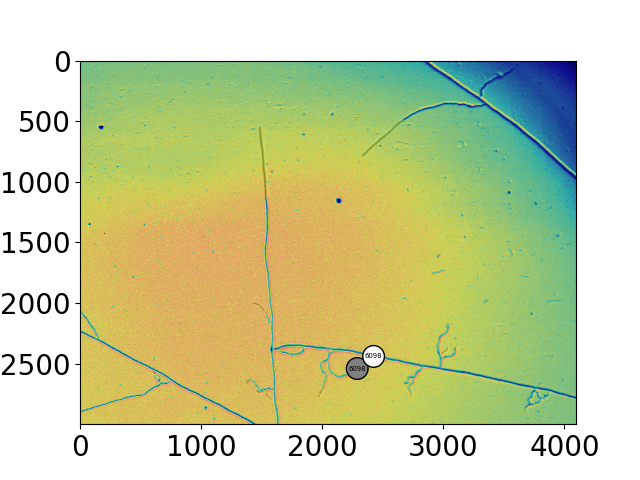

In [15]:
plt.close('all')
hyph.end.show_source_image(26,27)

In [21]:
get_time(exp,0,3)

20.0

In [50]:
%%timeit
for i,t in enumerate(hyph.ts[:-1]):
    tp1 = hyph.ts[i+1]
    if hyph.end.degree(t)==1 and hyph.end.degree(tp1)==3 and 1 not in [hyph.end.degree(t) for t in hyph.ts[i+1:]]:
        print(t)
        break

45.4 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [48]:
hyph.ts

[25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46]

In [12]:
exp.inconsistent_root = [1,2,3]

In [13]:
exp.reach_out

array(15)

In [27]:
from amftrack.pipeline.functions.image_processing.hyphae_id_surf import get_pixel_growth_and_new_children
from amftrack.pipeline.functions.post_processing.util import get_length_um


def get_time_since_start(hypha, t, tp1, args):
    exp = hypha.experiment
    seconds = (exp.dates[tp1]-exp.dates[hypha.ts[0]]).total_seconds()
    return("time_since_emergence",seconds/3600)


def get_time(hypha,t,tp1,args):
    exp = hypha.experiment
    seconds = (exp.dates[tp1]-exp.dates[t]).total_seconds()
    return("time",seconds/3600)


def get_speed(hypha,t,tp1,args):
    # try:
    pixels,nodes = get_pixel_growth_and_new_children(hypha,t,tp1)
    speed = np.sum([get_length_um(seg) for seg in pixels])/get_time(hypha,t,tp1,None)[1]
    return('speed',speed)
    # except:
    #     print('not_connected',hypha.end.label,hypha.get_root(tp1).label)
    #     return('speed',None)


In [25]:
hyph = choice(exp.hyphaes)


In [26]:
hyph.ts

[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [28]:
get_speed(hyph,12,13,None)

('speed', 7.352758861608384)

In [16]:
def prop_inconsistent_root(exp,args):
    return('inconsist_root',len(exp.inconsistent_root)/len(exp.hyphaes))

def number_of_timepoints_withing_boundaries(exp,args):
    return('num_timepoint_within', int(exp.reach_out))


In [17]:
number_of_timepoints_withing_boundaries(exp,[])

('num_timepoint_within', 15)

In [71]:
prop_inconsistent_root(exp,[])

('inconsist_root', 0.0007144558228149559)

In [63]:
prop_lost_tracks_junction(exp, [10])

('prop_lost_track_junction_lape10', 0.21663124335812964)

In [64]:
prop_lost_tracks_tips(exp, [10])

('prop_lost_track_tips_lape10', 0.17485251590514747)

In [35]:
lost = []
lapse = 1
for node in exp.nodes:
    t0 = node.ts()[0]
    if node.degree(t0) ==1 and t0 + lapse < exp.ts:
        if node.is_in(t0+lapse):
            pass
        else:
            lost.append(node)

[67, 68, 69, 70, 71, 72, 73]


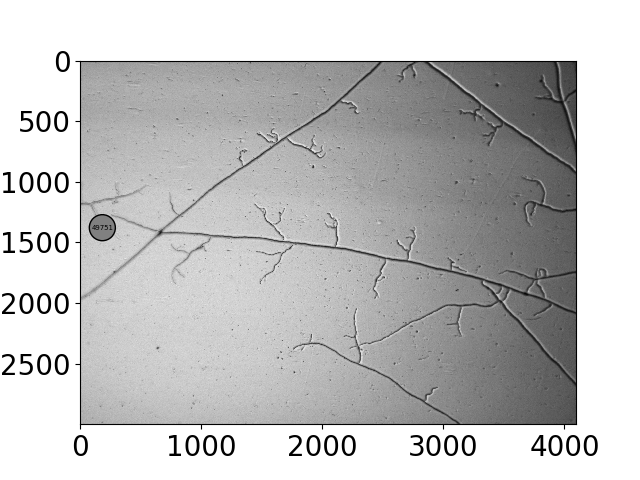

In [57]:
lost = []
tracked = 0
lapse = 1
# for node in exp.nodes:
#     t0 = node.ts()[0]
#     if node.degree(t0) >=3 and t0 + lapse < exp.ts:
#         if node.is_in(t0+lapse):
#             tracked+=len(node.ts())
#         else:
#             lost += len(node.ts())
for t in range(exp.ts-lapse):
    for node in exp.nodes:
        if node.is_in(t) and node.degree(t)>=3:
            if node.is_in(t+lapse):
                tracked+=1
            else:
                lost.append(node)


[92]


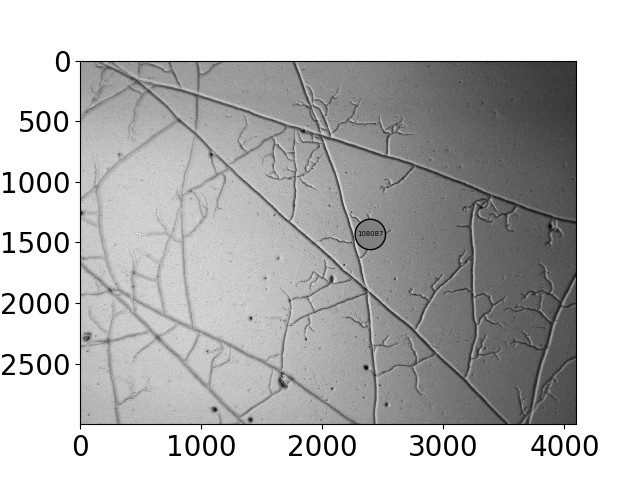

In [62]:
node = choice(lost)
t0 = node.ts()[0]
print(node.ts())
node.show_source_image(t0,t0)